In [33]:
import os
import re
import json
import requests
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from io import StringIO

In [2]:
# # 下載台中市不動產買賣實價登錄資料
# def datadownload(year, season):

#     download_url = f"https://plvr.land.moi.gov.tw/DownloadSeason?season={str(year)}S{str(season)}&fileName=B_lvr_land_A.csv"

#     # 進行下載
#     response = requests.get(download_url)
#     filename = f"real_estate_data_{year}S{season}.csv"

#     # 確保請求成功
#     if response.status_code == 200:
#         # 檢查回應的內容大小是否正確（假設空的CSV至少要有列標題），這裡設置1KB為下限 
#         if len(response.content) > 1024:  
#             # 使用 StringIO 來模擬一個檔案，讓 Pandas 可以讀取 CSV 內容
#             data = pd.read_csv(StringIO(response.content.decode('utf-8')), low_memory=False) 

#             data.rename(columns= {'車位移轉總面積(平方公尺)':'車位移轉總面積平方公尺'}, inplace = True) #欄位重新命名

#             return data
        
#         else:
#             return pd.DataFrame()
    
#     else:
#         return pd.DataFrame()

# taichung_data = pd.DataFrame()

# #合併所有檔案
# for year in range(101, 114):
    
#     for season in range(1, 5):
#         #刪除每個資料的英文欄位
#         data = datadownload(year, season).iloc[1:,:]
        
#         taichung_data = pd.concat([taichung_data, data], ignore_index=True)


# taichung_data.to_csv('taichung_house.csv', index=False)

### 篩選台中市102/1/1~113/3/31房地產買賣資料進行房價預測

In [343]:
df_taichung = pd.read_csv('taichung_house.csv')

# 篩選交易日期在2012/1/1~2024/3/31的資料
df_taichung = df_taichung[df_taichung['交易年月日'].between(1010101, 1130331)]

#將交易年月日、建築完成年月修改為西元年以及並轉為日期類型
date_columns = ['交易年月日','建築完成年月']
df_taichung['建築完成年月'] = pd.to_numeric(df_taichung['建築完成年月'], errors='coerce')
df_taichung[date_columns] = df_taichung[date_columns] + 19110000
df_taichung['交易年月日'] = pd.to_datetime(df_taichung['交易年月日'], format='%Y%m%d', errors='coerce')
df_taichung['建築完成年月'] = pd.to_datetime(df_taichung['建築完成年月'], format='%Y%m%d', errors='coerce')

#篩選為住家用
# df_taichung = df_taichung[(df_taichung['主要用途'] == '住家用')]

# 刪除備註交易，因備註交易大多為特殊交易(親友、特殊關係交易或增建等)
df_taichung = df_taichung[df_taichung['備註'].isna()]
df_taichung.drop(['備註'], axis= 1, inplace = True)

df_taichung.head()

C:\Users\erjac\AppData\Local\Temp\ipykernel_24456\1875215178.py:1: DtypeWarning: Columns (14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_taichung = pd.read_csv('taichung_house.csv')


,鄉鎮市區,交易標的,土地位置建物門牌,土地移轉總面積平方公尺,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易年月日,交易筆棟數,移轉層次,...,單價元平方公尺,車位類別,車位移轉總面積平方公尺,車位總價元,編號,主建物面積,附屬建物面積,陽台面積,電梯,移轉編號
0,豐原區,土地,南陽段897地號,134.70,住,NaN,NaN,2012-05-14,土地1建物0車位0,NaN,...,63103.0,NaN,0.0,0,RPPNMLOJQHHFFAL18CA,0.00,0.0,0.0,NaN,NaN
1,烏日區,土地,新榮和段141-9地號,174.31,住,NaN,NaN,2012-07-09,土地1建物0車位0,NaN,...,106018.0,NaN,0.0,0,RPTNMLPKQHHFFGL76CA,0.00,0.0,0.0,NaN,NaN
3,清水區,房地(土地+建物),台中市清水區和睦路５０巷１３１號,155.50,其他,一般農業區,丙種建築用地,2012-07-11,土地1建物1車位0,全,...,27256.0,NaN,0.0,0,RPSNMLKKQHHFFCL38CA,165.10,0.0,0.0,NaN,NaN
4,新社區,房地(土地+建物),台中市新社區華豐街３３０之１號,395.00,農,一般農業區,農牧用地,2012-07-16,土地1建物1車位0,一層,...,NaN,NaN,0.0,0,RPPNMLNJRHHFFEL58CA,109.66,0.0,0.0,NaN,NaN
5,潭子區,土地,摘星段1127地號,27.85,住,NaN,NaN,2012-07-20,土地1建物0車位0,NaN,...,35570.0,NaN,0.0,0,RPPNMLOJQHHFFFL68CA,0.00,0.0,0.0,NaN,NaN


---
## 類別型變數
**數據資訊**
- 非都市土地使用分區、非都市土地使用編定都有大量缺失，可能是因為只要此交易的被歸類在都市土地使用分區，非都市土地使用分區就會是空值，因此也可推斷大約9成的不動產交易都是在都市區的
- 交易筆棟數統一格式為「土地x建物x車位x」，應該可以再拆分為土地、建物、車位
- 移轉層次、總樓層數有部分缺失值，很可能是因為交易標的僅為土地，故總樓層和移轉層次都為空值
- 土地位置建物門牌、編號、車位類別可以考慮直接刪除
- 電梯也有大量缺失值，可能可以透過「建物型態」的資訊來補足部分缺失值
- 車位類別同樣有大量缺失直，可能沒有車位的就是缺失值，所以用交易筆棟數來判斷是否有車位會比較好
- 主要用途用都市土地使用分區(非都市土地使用區分)補足


**敘述統計**
- 最多交易的地區是北屯區，大約佔全台中15%，此外有40個缺失值，可以用土地位置建物門牌補足
- 交易標的住要為房地(土地+建物)+車位，大約占40%左右
- 都市土地使用大多是居住為主，大約佔都市區的70左右
- 非都市土地使用分區大部分是鄉村區
- 移轉層次、總樓層次需要轉為數值型變數。

In [279]:
df_taichung.select_dtypes(include=['object']).head()

,鄉鎮市區,交易標的,土地位置建物門牌,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易筆棟數,移轉層次,總樓層數,建物型態,主要用途,主要建材,建物現況格局-隔間,有無管理組織,車位類別,編號,電梯
0,豐原區,土地,南陽段897地號,住,NaN,NaN,土地1建物0車位0,NaN,NaN,其他,NaN,NaN,有,無,NaN,RPPNMLOJQHHFFAL18CA,NaN
1,烏日區,土地,新榮和段141-9地號,住,NaN,NaN,土地1建物0車位0,NaN,NaN,其他,NaN,NaN,有,無,NaN,RPTNMLPKQHHFFGL76CA,NaN
3,清水區,房地(土地+建物),台中市清水區和睦路５０巷１３１號,其他,一般農業區,丙種建築用地,土地1建物1車位0,全,三層,透天厝,住家用,鋼筋混凝土造,有,無,NaN,RPSNMLKKQHHFFCL38CA,NaN
4,新社區,房地(土地+建物),台中市新社區華豐街３３０之１號,農,一般農業區,農牧用地,土地1建物1車位0,一層,一層,農舍,農舍,鋼筋混凝土造,有,無,NaN,RPPNMLNJRHHFFEL58CA,NaN
5,潭子區,土地,摘星段1127地號,住,NaN,NaN,土地1建物0車位0,NaN,NaN,其他,NaN,NaN,有,無,NaN,RPPNMLOJQHHFFFL68CA,NaN


In [280]:
df_taichung.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 390337 entries, 0 to 570662
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   鄉鎮市區       390337 non-null  object
 1   交易標的       390337 non-null  object
 2   土地位置建物門牌   390337 non-null  object
 3   都市土地使用分區   346798 non-null  object
 4   非都市土地使用分區  40856 non-null   object
 5   非都市土地使用編定  40622 non-null   object
 6   交易筆棟數      390337 non-null  object
 7   移轉層次       316411 non-null  object
 8   總樓層數       316637 non-null  object
 9   建物型態       390337 non-null  object
 10  主要用途       316699 non-null  object
 11  主要建材       316678 non-null  object
 12  建物現況格局-隔間  390337 non-null  object
 13  有無管理組織     390337 non-null  object
 14  車位類別       161460 non-null  object
 15  編號         390337 non-null  object
 16  電梯         91559 non-null   object
dtypes: object(17)
memory usage: 53.6+ MB


In [281]:
df_taichung.describe(include='O')

,鄉鎮市區,交易標的,土地位置建物門牌,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易筆棟數,移轉層次,總樓層數,建物型態,主要用途,主要建材,建物現況格局-隔間,有無管理組織,車位類別,編號,電梯
count,390337,390337,390337,346798,40856,40622,390337,316411,316637,390337,316699,316678,390337,390337,161460,390337,91559
unique,29,5,340047,272,11,15,460,551,46,12,48,161,2,2,7,390336,2
top,北屯區,房地(土地+建物)+車位,臺中市南區工學一街１６９號地下一層,住,鄉村區,農牧用地,土地1建物1車位1,全,四層,住宅大樓(11層含以上有電梯),住家用,鋼筋混凝土造,有,有,坡道平面,RPVRMLPLNHIGFCB68DA,有
freq,56430,157733,120,256405,15142,15468,100783,76132,36956,154451,208867,286101,372311,227185,118079,2,56176


---
## 數值型變數
- 數據資訊
    - 用交易年月日和艦除完成年月日來計算大約的屋齡
    - 移轉面積平方公尺可能都需要改為「坪」為單位
    - 移轉編號可直接刪除

- 敘述統計
    - 總價元最低0元，最高12050000000

In [282]:
df_taichung.select_dtypes(exclude='object').head()

,土地移轉總面積平方公尺,交易年月日,建築完成年月,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,總價元,單價元平方公尺,車位移轉總面積平方公尺,車位總價元,主建物面積,附屬建物面積,陽台面積,移轉編號
0,134.70,2012-05-14,NaT,0.00,0,0,0,8500000,63103.0,0.0,0,0.00,0.0,0.0,NaN
1,174.31,2012-07-09,NaT,0.00,0,0,0,18480000,106018.0,0.0,0,0.00,0.0,0.0,NaN
3,155.50,2012-07-11,1995-04-20,165.10,3,1,2,4500000,27256.0,0.0,0,165.10,0.0,0.0,NaN
4,395.00,2012-07-16,1996-01-04,109.66,3,1,2,5560000,NaN,0.0,0,109.66,0.0,0.0,NaN
5,27.85,2012-07-20,NaT,0.00,0,0,0,990624,35570.0,0.0,0,0.00,0.0,0.0,NaN


In [283]:
df_taichung.select_dtypes(exclude=['object']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 390337 entries, 0 to 570662
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   土地移轉總面積平方公尺  390337 non-null  float64       
 1   交易年月日        390326 non-null  datetime64[ns]
 2   建築完成年月       315428 non-null  datetime64[ns]
 3   建物移轉總面積平方公尺  390337 non-null  float64       
 4   建物現況格局-房     390337 non-null  int64         
 5   建物現況格局-廳     390337 non-null  int64         
 6   建物現況格局-衛     390337 non-null  int64         
 7   總價元          390337 non-null  int64         
 8   單價元平方公尺      385715 non-null  float64       
 9   車位移轉總面積平方公尺  390337 non-null  float64       
 10  車位總價元        390337 non-null  int64         
 11  主建物面積        390337 non-null  float64       
 12  附屬建物面積       390337 non-null  float64       
 13  陽台面積         390337 non-null  float64       
 14  移轉編號         25003 non-null   float64       
dtypes: datetime64[ns](2), float64(8), int64

In [284]:
df_taichung.describe(exclude="O")

,土地移轉總面積平方公尺,交易年月日,建築完成年月,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,總價元,單價元平方公尺,車位移轉總面積平方公尺,車位總價元,主建物面積,附屬建物面積,陽台面積,移轉編號
count,390337.000000,390326,315428,390337.000000,390337.000000,390337.000000,390337.000000,3.903370e+05,3.857150e+05,3.903370e+05,3.903370e+05,390337.000000,390337.000000,390337.000000,25003.000000
mean,246.636550,2017-05-05 00:43:16.475766016,2003-09-05 19:27:27.909507072,137.952901,2.454779,1.416650,1.756492,1.381104e+07,5.987137e+04,2.766377e+01,2.377682e+05,90.389043,2.957860,6.291248,1583.822061
min,0.000000,2012-01-01 00:00:00,1911-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,15.520000,2014-04-18 00:00:00,1993-12-11 00:00:00,50.940000,1.000000,0.000000,1.000000,4.350000e+06,3.888250e+04,0.000000e+00,0.000000e+00,25.500000,0.000000,0.000000,770.000000
50%,26.550000,2017-03-03 00:00:00,2006-06-10 00:00:00,125.560000,3.000000,2.000000,2.000000,7.750000e+06,5.380900e+04,0.000000e+00,0.000000e+00,74.920000,0.000000,3.960000,1569.000000
75%,89.440000,2020-01-06 00:00:00,2015-09-24 00:00:00,179.100000,3.000000,2.000000,2.000000,1.300000e+07,7.347950e+04,1.362000e+01,0.000000e+00,111.860000,3.370000,10.060000,2374.000000
max,161451.100000,2024-02-23 00:00:00,2023-11-27 00:00:00,308284.340000,156.000000,65.000000,161.000000,1.205000e+10,6.490232e+07,2.400000e+06,3.630000e+07,74431.020000,861.560000,5545.980000,3714.000000
std,1260.311373,NaN,NaN,633.806536,2.130196,1.035451,1.886668,5.721952e+07,1.264201e+05,5.921514e+03,6.952264e+05,298.257296,7.570204,12.635109,942.401830


---
## 數據清理與調整

-  **平方公尺轉坪：土地移轉總面積平方公尺、建物移轉總面積平方公尺、車位移轉總面積平方公尺、主建物面積、附屬建物面積**

-  **新增總面積**

In [344]:
# 新增總面積
df_taichung['總面積平方公尺'] = df_taichung['土地移轉總面積平方公尺'] + df_taichung['建物移轉總面積平方公尺'] + df_taichung['車位移轉總面積平方公尺']

# 平方公尺轉坪數
change_list = ['土地移轉總面積平方公尺','建物移轉總面積平方公尺','車位移轉總面積平方公尺','主建物面積','附屬建物面積','總面積平方公尺']
df_taichung[change_list] = round(df_taichung[change_list] * 0.3205,2)

#先將單價元的單位轉為坪數
df_taichung['單價元平方公尺'] = round(df_taichung['單價元平方公尺'] / 0.3205,2)

#面積、單價元欄位單位改為坪數
df_taichung.rename(columns={'土地移轉總面積平方公尺':'土地移轉總坪數',
                            '建物移轉總面積平方公尺':'建物移轉總面積平方公尺',
                            '車位移轉總面積平方公尺':'車位移轉總面積平方公尺',
                            '主建物面積':'主建物坪數',
                            '附屬建物面積':'附屬建物坪數',
                            '總面積平方公尺':'總坪數',
                            '單價元平方公尺':'單價元坪數'}, inplace= True)


df_taichung.select_dtypes(exclude='object').head()

,土地移轉總坪數,交易年月日,建築完成年月,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,總價元,單價元坪數,車位移轉總面積平方公尺,車位總價元,主建物坪數,附屬建物坪數,陽台面積,移轉編號,總坪數
0,43.17,2012-05-14,NaT,0.00,0,0,0,8500000,196889.24,0.0,0,0.00,0.0,0.0,NaN,43.17
1,55.87,2012-07-09,NaT,0.00,0,0,0,18480000,330789.39,0.0,0,0.00,0.0,0.0,NaN,55.87
3,49.84,2012-07-11,1995-04-20,52.91,3,1,2,4500000,85042.12,0.0,0,52.91,0.0,0.0,NaN,102.75
4,126.60,2012-07-16,1996-01-04,35.15,3,1,2,5560000,NaN,0.0,0,35.15,0.0,0.0,NaN,161.74
5,8.93,2012-07-20,NaT,0.00,0,0,0,990624,110982.84,0.0,0,0.00,0.0,0.0,NaN,8.93


- ### 針對價格或面積進行極端值排除

In [345]:
q1 = np.percentile(df_taichung['總價元'],25)
q3 = np.percentile(df_taichung['總價元'],75)
iqr = q3 - q1
upper = q3 + 1.5*iqr

# lower 若是Q1 - 1.5iqr 會是負數，故下限僅設定大於0
df_taichung = df_taichung[(df_taichung['總價元'] <= upper) & (df_taichung['總價元'] > 0)]

In [346]:
q1 = np.percentile(df_taichung['總坪數'],25)
q3 = np.percentile(df_taichung['總坪數'],75)
iqr = q3 - q1
upper = q3 + 1.5*iqr

df_taichung = df_taichung[(df_taichung['總坪數'] <= upper) & (df_taichung['總坪數'] > 0)]

In [347]:
df_taichung[['總坪數','總價元']].describe()

,總坪數,總價元
count,334442.000000,3.344420e+05
mean,58.267609,7.987979e+06
std,31.065424,5.398241e+06
min,0.010000,1.580000e+02
25%,36.620000,4.020000e+06
50%,55.980000,7.050000e+06
75%,77.550000,1.080000e+07
max,152.420000,2.597000e+07


### 轉移層次
中文層數改阿拉伯數字，並且分類低中高層、全、單層

In [348]:
#中文數自轉阿拉伯數字表
convert_table = {'零': 0, '一': 1, '二': 2, '兩': 2, '三': 3, '四': 4, '五': 5,'六': 6, '七': 7, '八': 8, '九': 9, '十': 10,'百':100}

def chinese_number_to_arabic(chinese_str):
    total = 0
    unit = 0  # 最近的單位數
    num = 0   # 基數（一、二、三...九）

    for char in reversed(chinese_str):  # 從最小單位開始計算
        if char in convert_table:
            value = convert_table[char]
            if value >= 10:
                unit = value  # 設定單位為十、百...等
            else:
                num = value
                if unit > 0:
                    total += num * unit  # 如果已設定單位，乘以基數
                    unit = 0  # 重置單位
                else:
                    total += num  # 如果沒有單位，直接加基數

    if unit > 0:  # 處理單獨的「十」
        total += unit

    return total



#定義樓層轉換
def classify_floors(floor):
    if pd.isna(floor):
        return None
    elif floor == '全':
        return '全棟'
    elif '，' in floor or '及' in floor or '與' in floor:
        return '多層'
    else:
        match = re.match(r'^([零一二兩三四五六七八九十]+)層$', floor)
        if match:
            num_floors = chinese_number_to_arabic(match.group(1))
            if num_floors <= 5:
                return '低層'
            elif num_floors <= 10:
                return '中層'
            else:
                return '高層'
    return '其他'  # 如果匹配不成功，分類為其他

df_taichung['移轉層次分類'] = df_taichung['移轉層次'].apply(classify_floors)

df_taichung[['移轉層次分類','移轉層次']].head(30)

df_taichung[['移轉層次分類','單價元坪數']].groupby('移轉層次分類',as_index=False).mean().sort_values(by=['單價元坪數'], ascending = False)

,移轉層次分類,單價元坪數
5,高層,201511.801908
2,全棟,199645.522010
4,多層,196161.145445
0,中層,180918.721115
1,低層,171355.837818
3,其他,125056.349248


- ### **透過交易標的、建物型態補足電梯缺失值**

    - 住宅大樓(11層含以上有電梯)、華廈(10層含以下有電梯) = 有

    - 公寓(5樓含以下無電梯) = 無

In [354]:
df_taichung['電梯'].isna().sum()

df_taichung.loc[df_taichung['交易標的'].isin(['土地','車位']), '電梯'].isna().sum() #土地跟車位應該不會跟電梯有關?

32860

In [355]:
df_taichung.loc[df_taichung['交易標的'].isin(['土地','車位']), '電梯'].value_counts() #大部分純購買土地跟車位的都無電梯==

電梯
無    8927
有      15
Name: count, dtype: int64

In [350]:
df_taichung['交易標的'].value_counts()

交易標的
房地(土地+建物)+車位    145780
房地(土地+建物)       145688
土地               38273
車位                3529
建物                1172
Name: count, dtype: int64

In [349]:
df_taichung['建物型態'].value_counts()

建物型態
住宅大樓(11層含以上有電梯)    145030
透天厝                 66249
華廈(10層含以下有電梯)       42833
其他                  42100
公寓(5樓含以下無電梯)        16928
套房(1房1廳1衛)          14784
店面(店鋪)               4276
辦公商業大樓               2020
工廠                     81
廠辦                     74
農舍                     52
倉庫                     15
Name: count, dtype: int64

In [295]:
#建物型態包含電梯值且電梯為缺失值轉換為「有」
df_taichung.loc[df_taichung['建物型態'].str.contains('有電梯'), '電梯'] = '有'
df_taichung.loc[df_taichung['建物型態'].str.contains('無電梯'), '電梯'] = '無'
df_taichung['電梯'].value_counts()

電梯
有    180958
無     35114
Name: count, dtype: int64

In [308]:
df_taichung.loc[df_taichung['交易標的'].isin(['土地','車位']),  '電梯'].isna().sum()/len(df_taichung)

0.09768193627613464

In [301]:
df_taichung['電梯'].isna().sum()/len(df_taichung)

0.31789641162599086

- ### 統整建物型態

In [331]:
# df_taichung['交易標的'].value_counts()
df_taichung['建物型態'].value_counts()

建物型態
住宅大樓(11層含以上有電梯)    145030
透天厝                 66249
華廈(10層含以下有電梯)       42833
其他                  42100
公寓(5樓含以下無電梯)        16928
套房(1房1廳1衛)          14784
店面(店鋪)               4276
辦公商業大樓               2020
工廠                     81
廠辦                     74
農舍                     52
倉庫                     15
Name: count, dtype: int64

In [342]:
df_taichung.loc[df_taichung['交易標的'].isin(['土地','車位']), '建物型態'] = '其他'
df_taichung.loc[~df_taichung['建物型態'].isin(['住宅大樓(11層含以上有電梯)','華廈(10層含以下有電梯)','公寓(5樓含以下無電梯)','透天厝','套房(1房1廳1衛)']), '建物型態'] = '其他'
df_taichung['建物型態'].value_counts()

建物型態
住宅大樓(11層含以上有電梯)    144966
透天厝                 66212
其他                  48761
華廈(10層含以下有電梯)       42815
公寓(5樓含以下無電梯)        16907
套房(1房1廳1衛)          14781
Name: count, dtype: int64

- 整理主要用途分類：

1. 將包含「住」但不在「住商用、住家用、住公用、住商辦用」的主要用途統一歸類到「住家用」
    
2. 接著將不是「住商用、住家用、辦公用、商業用、其他」的主要用途統一歸類到「其他」

In [296]:
df_taichung.loc[(df_taichung['主要用途'].str.contains('住')) & \
                ~(df_taichung['主要用途'].isin(['住商用','住家用','住工用','住商辦用'])), '主要用途'] = '住家用'

df_taichung.loc[~df_taichung['主要用途'].isin(['住家用','住商用','商業用','辦公用','其他']), '主要用途'] = '其他'

df_taichung['主要用途'].value_counts()

主要用途
住家用    189950
其他     107751
住商用     11433
商業用      6522
辦公用      1117
Name: count, dtype: int64

In [277]:
df_taichung[['主要用途','總價元']].groupby('主要用途',as_index= False).mean().sort_values(by = '總價元',ascending=False)

,主要用途,總價元
4,辦公用,3.298507e+07
2,其他,1.913486e+07
3,商業用,1.491130e+07
0,住商用,1.357088e+07
1,住家用,9.613634e+06


,總坪數,總價元
count,356241.000000,3.562410e+05
mean,100.390385,8.145276e+06
std,1536.928703,5.603675e+06
min,0.000000,1.030000e+02
25%,38.000000,4.000000e+06
50%,58.650000,7.127000e+06
75%,83.770000,1.100000e+07
max,625049.220000,2.597000e+07


---
### EDA

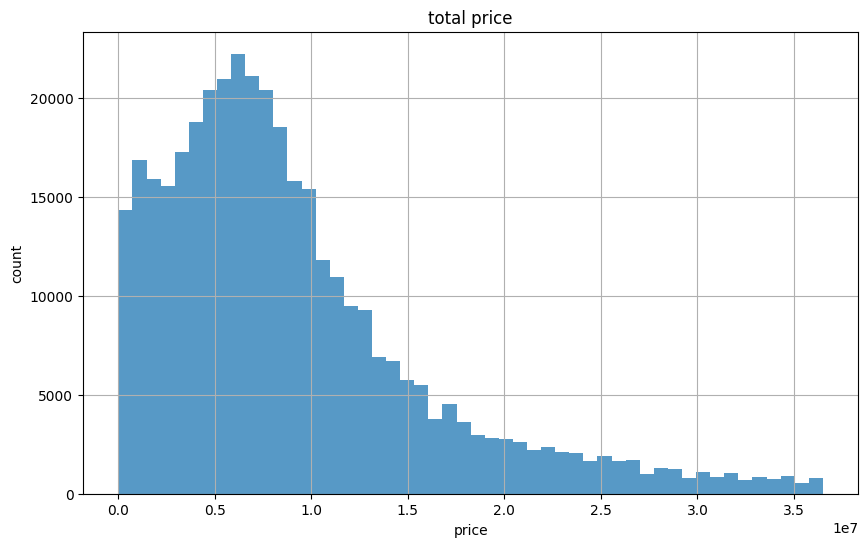

In [222]:
filtered_data = df_taichung[(df_taichung['總價元'] <= np.percentile(df_taichung['總價元'], 95)) & (df_taichung['總價元'] > 0)]

plt.figure(figsize=(10, 6))
filtered_data['總價元'].hist(bins=50, alpha=0.75)
plt.title('total price')
plt.xlabel('price')
plt.ylabel('count')
plt.show()